In [551]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


#### Get Data

In [625]:
# Training
formation_start_date = datetime.fromisoformat('2021-07-01 00:00:00+00:00')
formation_end_date = datetime.fromisoformat('2021-09-01 00:00:00+00:00')
minimum_volume = 5000000
resolution = '1h'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('/Users/walidmadaoui/Desktop/ARB/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

formation_prices_df = pd.DataFrame(prices)[formation_start_date:formation_end_date].T.dropna().T
formation_prices_df

,1INCH-PERP,AAVE-PERP,ADA-PERP,ALGO-PERP,ALT-PERP,AR-PERP,ATOM-PERP,AVAX-PERP,AXS-PERP,BCH-PERP,...,VET-PERP,WAVES-PERP,XLM-PERP,XMR-PERP,XRP-PERP,XTZ-PERP,YFI-PERP,YFII-PERP,ZEC-PERP,ZIL-PERP
startTime,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00+00:00,2.4837,248.33,1.366875,0.8695,3292.20,10.242,11.7100,11.839,5.523,520.05,...,0.090170,15.8280,0.278725,218.26,0.691975,3.0187,33620.0,1949.00,128.79,0.08615
2021-07-01 01:00:00+00:00,2.4957,250.02,1.371350,0.8826,3311.40,10.217,11.8705,11.931,5.590,524.60,...,0.090045,15.9340,0.281175,219.45,0.694675,3.0570,33865.0,2067.50,129.26,0.08693
2021-07-01 02:00:00+00:00,2.4209,243.01,1.346280,0.8568,3232.75,10.177,11.5920,11.523,5.382,512.00,...,0.086640,15.5570,0.272675,212.16,0.677375,3.0055,33095.0,2079.50,125.26,0.08445
2021-07-01 03:00:00+00:00,2.4046,243.00,1.338005,0.8486,3205.90,10.512,11.4685,11.423,5.405,508.20,...,0.085650,15.5840,0.270450,210.26,0.673350,2.9676,32980.0,2064.25,124.14,0.08276
2021-07-01 04:00:00+00:00,2.4351,247.94,1.347970,0.8591,3234.05,10.593,11.5585,11.577,5.425,513.20,...,0.087720,15.3010,0.272700,213.50,0.680200,3.0187,33490.0,2095.75,125.16,0.08386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 20:00:00+00:00,3.0151,384.00,2.760005,1.0909,5379.70,63.328,22.8275,39.421,71.901,634.05,...,0.123795,27.3345,0.342800,288.03,1.183325,5.1595,37835.0,6552.75,143.97,0.10746
2021-08-31 21:00:00+00:00,3.0241,390.01,2.754220,1.0820,5372.50,60.681,22.6140,39.817,72.185,632.25,...,0.123380,27.4805,0.342950,286.20,1.180000,5.0638,38375.0,6263.00,144.08,0.10693
2021-08-31 22:00:00+00:00,3.0444,390.66,2.763455,1.0981,5377.40,64.771,22.5155,39.253,72.341,634.50,...,0.122275,27.5190,0.342625,286.04,1.174350,5.1114,38170.0,6294.50,143.26,0.10778


#### Functions

In [666]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


def get_trades(df, entry, mean, stop):
    trades = []
    long_entry = mean - entry
    short_entry = mean + entry
    long_stop = mean - stop
    short_stop = mean + stop
    current_pos = 0
    for i in range(2, len(df)):
        if current_pos == 0 and df.iloc[i-1] < long_entry.iloc[i-1] and df.iloc[i] > long_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open long', 'position': 1})
            current_pos = 1
        elif current_pos == 0 and df.iloc[i-1] > short_entry.iloc[i-1] and df.iloc[i] < short_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open short', 'position': -1})
            current_pos = -1
        elif current_pos == 1 and df.iloc[i] >= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] <= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] >= short_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0})
            current_pos = 0
        elif current_pos == 1 and df.iloc[i] <= long_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0})
            current_pos = 0
        elif i == len(df) - 1 and current_pos == -1:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0})
        elif i == len(df) - 1 and current_pos == 1:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0})
        else:
            continue
    
    return pd.DataFrame(trades)

#### Narrow down coin universe

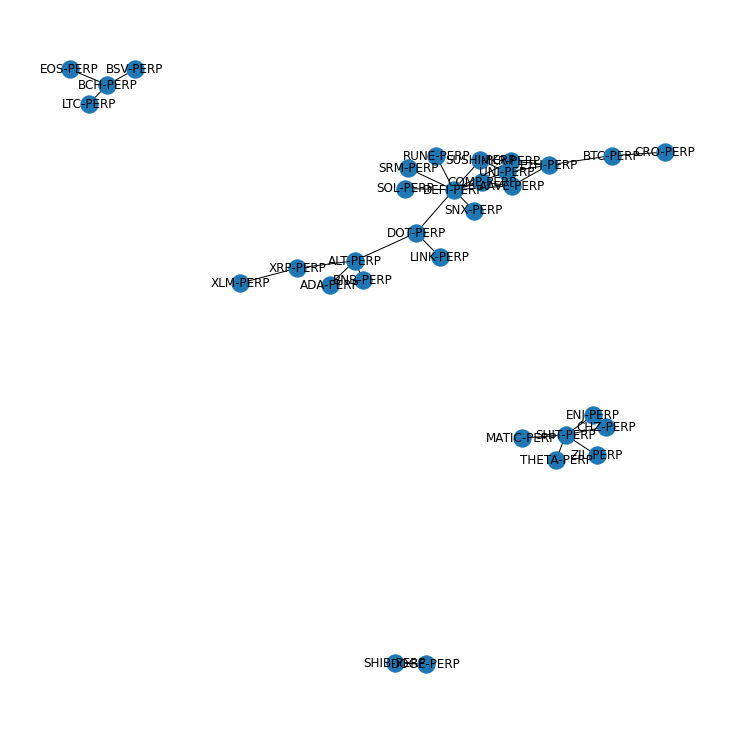

In [626]:
returns = formation_prices_df.pct_change()[1:]

edge_model = covariance.GraphicalLassoCV()
returns /= returns.std(axis=0)
edge_model.fit(returns)
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=formation_prices_df.columns, index=formation_prices_df.columns)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.1) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

#### Identify best pair candidates

In [627]:
# Find most mean reverting pairs
ridge = RidgeCV()
unique_pairs = []
possible_pairs = []
clusters = nx.connected_components(G)
for cluster in clusters:
    perps = list(cluster)
    for perp_a in perps:
        for perp_b in perps:
            pair = '{}/{}'.format(perp_a, perp_b)
            if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                
                # regress prices
                ridge_reg = ridge.fit(formation_prices_df[perp_a].values.reshape(-1, 1), formation_prices_df[perp_b].values.reshape(-1, 1))

                # test for mean-reversion
                spread =  formation_prices_df[perp_b] - ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                half_life = calculat_half_life(spread)
                adf = adfuller(spread, 1)
                hurst = calculate_hurst(spread)

                # calculate positions ratio in dollars
                total_size = formation_prices_df[perp_b] + ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                size_ratio = formation_prices_df[perp_b] / total_size

                possible_pairs.append({
                    'pair': pair,
                    'perp_a': perp_a,
                    'perp_b': perp_b,
                    'beta_units': ridge_reg.coef_[0][0],
                    'half_life': half_life,
                    'adf_pvalue': adf[1],
                    'hurst': hurst,
                    'long_short_position_ratio': size_ratio.mean()
                })

                unique_pairs.append(pair)

possible_pairs = pd.DataFrame(possible_pairs)
top_10_pairs = possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['hurst'])[:10]
top_10_pairs

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio
193,BCH-PERP/BSV-PERP,BCH-PERP,BSV-PERP,0.173890,22.308119,0.001225,0.282834,0.604414
195,BSV-PERP/LTC-PERP,BSV-PERP,LTC-PERP,1.435131,22.273770,0.000982,0.292040,0.415267
199,SHIT-PERP/ZIL-PERP,SHIT-PERP,ZIL-PERP,0.000017,20.188991,0.000021,0.297340,0.489735
191,EOS-PERP/BSV-PERP,EOS-PERP,BSV-PERP,21.617673,36.083562,0.014457,0.324431,0.609834
203,CHZ-PERP/ZIL-PERP,CHZ-PERP,ZIL-PERP,0.288141,40.766044,0.003596,0.328071,0.506260
72,SOL-PERP/SRM-PERP,SOL-PERP,SRM-PERP,0.080749,77.645926,0.385443,0.336101,0.562232
196,SHIT-PERP/CHZ-PERP,SHIT-PERP,CHZ-PERP,0.000054,34.665268,0.009085,0.339685,0.505930
210,ZIL-PERP/ENJ-PERP,ZIL-PERP,ENJ-PERP,12.157309,85.451432,0.153379,0.356527,0.582595
190,EOS-PERP/BCH-PERP,EOS-PERP,BCH-PERP,123.839940,45.063812,0.011177,0.360755,0.506653
194,BCH-PERP/LTC-PERP,BCH-PERP,LTC-PERP,0.262458,24.413878,0.000706,0.361171,0.507836


### Backtest

In [656]:
trading_period_hours = 24*5
trading_start_date = formation_end_date
trading_end_date = trading_start_date + timedelta(hours=trading_period_hours)
trading_prices_df = pd.DataFrame(prices)[trading_start_date - timedelta(hours=trading_period_hours):trading_end_date].T.dropna().T

trading_data = {}
#for row in top_10_pairs


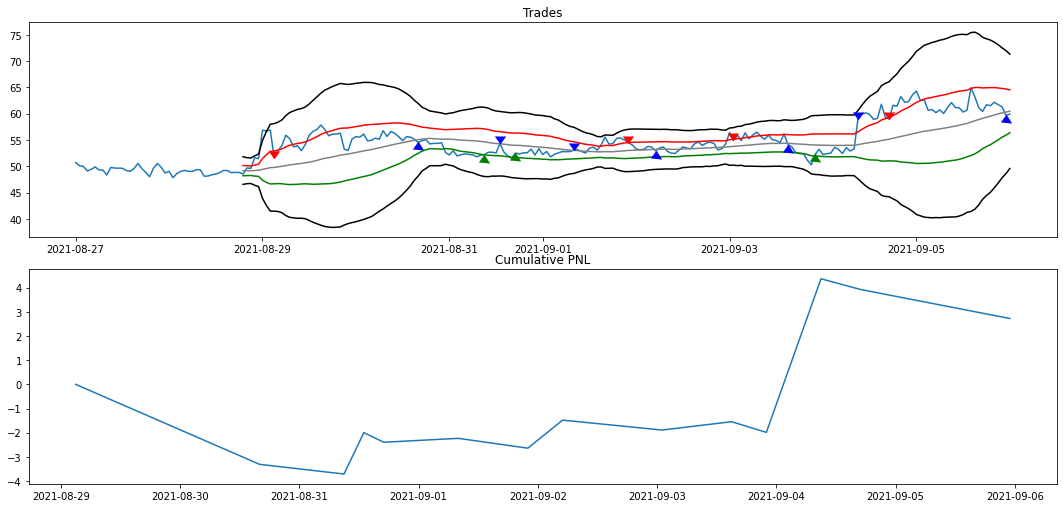

In [723]:
taker_fee = 0.0005
std_entry_multiple = 1.5
std_stop_multiple = 4
half_life_multiple = 2

row = top_10_pairs.iloc[0]
formation_spread = (formation_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
formation_mean = formation_spread.mean()
formation_std = formation_spread.std()

# trades
trading_spread = (trading_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
rolling_mean = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.mean)
rolling_std = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.std)
rolling_entry = std_entry_multiple * rolling_std
rolling_stop = std_stop_multiple * rolling_std
trades = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

# pnl
trades_fee = (trading_prices_df.loc[trades['date'], [row['perp_a'], row['perp_b']]] * taker_fee).sum(axis=1)
trades_pnl = trading_spread[trades['date']].diff() * trades['position'].shift(1).values - trades_fee
trades_pnl[0] = 0
cumulative_pnl = trades_pnl.cumsum()

# visualization
fig, axs = plt.subplots(2,1, figsize=(15,7))
fig.tight_layout()
axs[0].plot(trading_spread)
axs[0].title.set_text('Trades')
axs[0].plot(rolling_mean, color='grey')
axs[0].plot(rolling_mean + rolling_entry, color='red')
axs[0].plot(rolling_mean + rolling_stop, color='black')
axs[0].plot(rolling_mean - rolling_entry, color='green')
axs[0].plot(rolling_mean - rolling_stop, color='black')
axs[0].plot(trading_spread[trades[trades['trade'] == 'open short']['date']], linestyle='None', marker=7, color='r', markersize=10)
axs[0].plot(trading_spread[trades[trades['trade'] == 'open long']['date']], linestyle='None', marker=6, color='g', markersize=10)
axs[0].plot(trading_spread[trades[trades['trade'] == 'close short']['date']], linestyle='None', marker=6, color='b', markersize=10)
axs[0].plot(trading_spread[trades[trades['trade'] == 'close long']['date']], linestyle='None', marker=7, color='b', markersize=10)

axs[1].plot(cumulative_pnl)
axs[1].title.set_text('Cumulative PNL')


In [722]:
trades_pnl

startTime
2021-08-29 03:00:00+00:00         NaN
2021-08-30 16:00:00+00:00   -3.309324
2021-08-31 09:00:00+00:00   -0.401925
2021-08-31 13:00:00+00:00    1.713147
2021-08-31 17:00:00+00:00   -0.397760
2021-09-01 08:00:00+00:00    0.161898
2021-09-01 22:00:00+00:00   -0.407235
2021-09-02 05:00:00+00:00    1.161057
2021-09-03 01:00:00+00:00   -0.410720
2021-09-03 15:00:00+00:00    0.345348
2021-09-03 22:00:00+00:00   -0.440800
2021-09-04 09:00:00+00:00    6.355635
2021-09-04 17:00:00+00:00   -0.445395
2021-09-05 23:00:00+00:00   -1.198815
dtype: float64

In [721]:
trading_spread[trades['date']].diff() * trades['position'].shift(1).values

startTime
2021-08-29 03:00:00+00:00         NaN
2021-08-30 16:00:00+00:00   -2.902839
2021-08-31 09:00:00+00:00   -0.000000
2021-08-31 13:00:00+00:00    2.118802
2021-08-31 17:00:00+00:00   -0.000000
2021-09-01 08:00:00+00:00    0.564078
2021-09-01 22:00:00+00:00    0.000000
2021-09-02 05:00:00+00:00    1.577012
2021-09-03 01:00:00+00:00    0.000000
2021-09-03 15:00:00+00:00    0.787428
2021-09-03 22:00:00+00:00   -0.000000
2021-09-04 09:00:00+00:00    6.810875
2021-09-04 17:00:00+00:00   -0.000000
2021-09-05 23:00:00+00:00   -0.720015
dtype: float64

In [718]:
trades.shift(1)

,date,trade,position
0,NaT,NaN,NaN
1,2021-08-29 03:00:00+00:00,open short,-1.0
2,2021-08-30 16:00:00+00:00,close short,0.0
3,2021-08-31 09:00:00+00:00,open long,1.0
4,2021-08-31 13:00:00+00:00,close long,0.0
5,2021-08-31 17:00:00+00:00,open long,1.0
6,2021-09-01 08:00:00+00:00,close long,0.0
7,2021-09-01 22:00:00+00:00,open short,-1.0
8,2021-09-02 05:00:00+00:00,close short,0.0
9,2021-09-03 01:00:00+00:00,open short,-1.0
